# For a given "lake" boundary contour, 
### we will want to composite gridded quantities by distance from the border. 
### As a first step, let's capture the bounding box (plus a buffer of say 3 degrees).  

Raster is the GIS name for a grid. Step 1 is to grab the area around a lake' shape *bounds* as a square xarray subset. Later we can build the distance from the boundary composites. Need to define a dataset saving strategy: for each lake, at each time, we will have a raster array that is say 2 degrees bigger on all sides than the bounds (bounding box). Perhaps all those one-raster files should go in a folder by dataset name, in a folder for the lake's name (landfall time and centroid of landfall, a unique string). 

Or will I never want this square-grids dataset, redundant as it is with the total grid, or subsets I could make for just the WEIO region? Well for one case, it will facilitate experimentation without logging on to massive data servers. 

Shapely [object.buffer](https://shapely.readthedocs.io/en/stable/manual.html#spatial-analysis-methods)(distance, resolution=16, cap_style=1, join_style=1, mitre_limit=5.0, single_sided=False) looks promising for measuring distance from the border. 

Single-sided may suffice to distinguish inside from ourside, or [object.contains(other)](https://shapely.readthedocs.io/en/stable/manual.html#predicates-and-relationships) applies to all types, and is inverse to within(). 

For xarray bounding-box grabs, we may want the outermost [polygon.bounds](https://shapely.readthedocs.io/en/stable/manual.html#polygons). This x-y bounding box is a (minx, miny, maxx, maxy) tuple.

rasterio is a common package for "rasterizing" a geometric object like a polygon, and [rioxarray](https://corteva.github.io/rioxarray/stable/examples/examples.html) is its interface with grids, and [regionmask](https://regionmask.readthedocs.io/en/stable/notebooks/geopandas.html) is anothe wrapper for rasterizing apparently

Old: "Geopandas is [terribly slow, so shapely vectorized is preferred](http://paisheng.me/2018/12/06/Methods-to-mask-raster-by-polygons/)... 

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import geopandas as gp
from datetime import datetime

## Let's grab a case in 2014-2018 so the data are on weather2 

In [59]:
filename = '2019_10_11_02_lat5p153S.geojson'
gdf = gp.read_file('GEOJSONS/'+filename)
gdf

,tqv_values,area,maxlon,time,tag,geometry
0,55,1.139115233846996,40.23633763849722,2019-10-11T02:00:00,2019_10_11_02_lat5p153S,"POLYGON ((39.37500 -5.84703, 39.87505 -5.50000..."
1,55,2.073919292503562,40.51889641849626,None,2019_10_11_02_lat5p153S,"POLYGON ((38.75000 -6.43156, 39.37500 -6.21352..."
2,55,2.743447702914805,40.78104620383396,2019-10-11T00:00:00,2019_10_11_02_lat5p153S,"POLYGON ((38.75000 -6.69891, 39.37500 -6.59282..."
3,55,3.30449137952792,40.94174699747155,2019-10-10T23:00:00,2019_10_11_02_lat5p153S,"POLYGON ((38.75000 -6.80484, 39.37500 -6.90424..."
4,55,3.720181205260852,41.15083471128543,None,2019_10_11_02_lat5p153S,"POLYGON ((39.37500 -7.19896, 39.60291 -7.00000..."
...,...,...,...,...,...,...
472,55,6.778436416330973,69.51767394921168,2019-10-03T08:00:00,2019_10_11_02_lat5p153S,"POLYGON ((64.37500 -7.62986, 65.00000 -7.69709..."
473,55,5.979332838557839,69.7070180413013,None,2019_10_11_02_lat5p153S,"POLYGON ((64.37500 -7.56224, 65.00000 -7.73942..."
474,55,5.026806410951192,69.88870080456022,2019-10-03T06:00:00,2019_10_11_02_lat5p153S,"POLYGON ((65.00000 -7.66394, 65.62500 -7.85128..."
475,55,4.013025817837683,70.07214503008856,2019-10-03T05:00:00,2019_10_11_02_lat5p153S,"POLYGON ((65.62500 -7.82479, 66.25000 -7.82577..."


<AxesSubplot:>

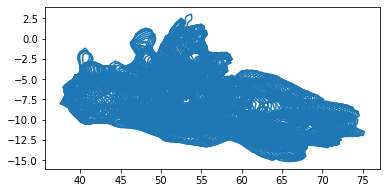

In [80]:
gdf.boundary.plot() # a "line collection"

<AxesSubplot:>

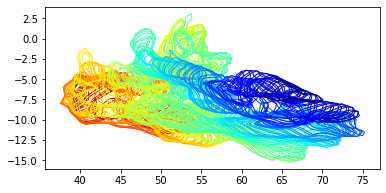

In [82]:
gdf.plot(column='time', facecolor='none', cmap='jet') #, alpha=1) #, legend=True)

Text(0.5, 1.0, 'case study')

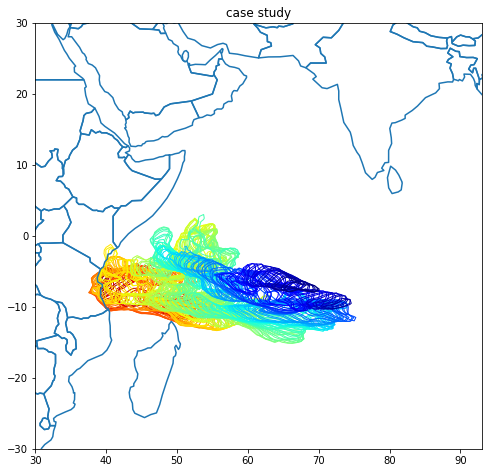

In [85]:
fig, ax = plt.subplots(figsize=[8,8])
ax.set_aspect('equal')
ax.set_xlim(30, 93)
ax.set_ylim(-30,30)

gdf.plot(ax=ax, column='time', facecolor='none', \
                cmap='jet', alpha=1) #, legend=True)

#gdf.boundary.plot(ax=ax, color='black')
path = gp.datasets.get_path('naturalearth_lowres') # Geography background
mapdf = gp.read_file(path)
mapdf.boundary.plot(ax=ax)
    
ax.set_title('case study')

/var/folders/v9/8pr92c8s0m14426rc7jfm2c80000gn/T/ipykernel_14591/2265753485.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  plt.plot(gdf.geometry.area)


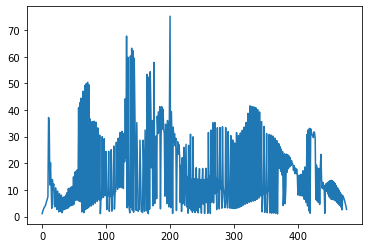

In [113]:
plt.plot(gdf.geometry.area)

In [106]:
gdf.area.argmax()

/var/folders/v9/8pr92c8s0m14426rc7jfm2c80000gn/T/ipykernel_14591/4119110822.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.area.argmax()


200

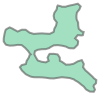

In [107]:
blob = gdf.iloc[200].geometry
blob

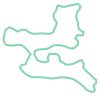

In [108]:
bnd = blob.boundary
bnd

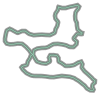

In [110]:
bnd.buffer(0.4, single_sided=True) # units are degrees

In [112]:
blob.bounds

(43.437352007562, -12.827914900921087, 57.88947944561048, 0.913970313462633)

In [115]:
blob.centroid.bounds

(51.19759881669136,
 -6.1110965953878935,
 51.19759881669136,
 -6.1110965953878935)